In [1]:
pip install laplace-torch wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.5/263.5 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import datetime
from copy import deepcopy

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import utils
from torch.optim import Adam
from torch.nn import CrossEntropyLoss, MSELoss
from torch.nn.utils import parameters_to_vector, vector_to_parameters


from laplace import Laplace, marglik_training
from laplace.utils import expand_prior_precision
from laplace.curvature import AsdlGGN, BackPackGGN


Below we train a Convolutional Neural Network (CNN) using a standard frequentist approach and the Laplace approximation.

# Vanilla LeNet

## F-MNIST

Following the authors' work we choose Fashion-MNIST dataset as a benchmark.

In [3]:
import wandb

# Added support for weights and biases logging
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

batch_size = 4

device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"device: {device}" )

training_set = torchvision.datasets.FashionMNIST('./data', train=True,
                                                 transform=transform,
                                                 download=True,
                                                 )
validation_set = torchvision.datasets.FashionMNIST('./data',
                                                   train=False,
                                                   transform=transform,
                                                   download=True)

training_loader = torch.utils.data.DataLoader(training_set,
                                              batch_size=batch_size,
                                              num_workers=0,
                                              shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set,
                                                batch_size=batch_size,
                                                num_workers=0,
                                                shuffle=False)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

device: cuda


100%|██████████| 26421880/26421880 [00:02<00:00, 11700994.78it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 201154.79it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3757641.62it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20048539.45it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Training set has 60000 instances
Validation set has 10000 instances


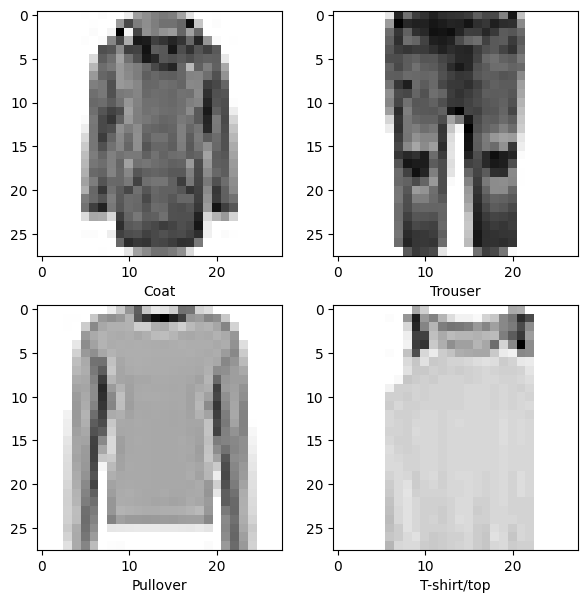

In [5]:
data, labels = next(iter(training_loader))
plt.figure(figsize=(7, 7))
for i, im in enumerate(data):
    plt.subplot(2, 2, i+1)
    plt.xlabel(classes[labels[i]])
    plt.imshow(im.reshape(28, 28, 1), cmap=plt.cm.binary)
plt.show()

## The model

We use a standard implementation of LeNet suggested by LeCun et al (1998). This CNN is lightweight and achieves decent performance on Fashion-MNIST. The same network was used by the authors to compare performance of Laplace with different approximations of the Hessian.

In [6]:
class LeNet(nn.Module):
    def __init__(self, n_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


First we train the model with the standard frequentist approach. To preserve the idea of an implicit prior we add a weight decay term ($l_2$ regularisation ). It should be noted that the default implementation of weight decay in the Adam optimiser is different from adding a penalty term to the loss function. Thus, we use the AdamW optimiser that fixes weight decay in Adam. This does not impact the performance of our model in any significant way.

In [7]:
def train_one_epoch(epoch_index, wandb_run=None):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(training_loader):
        optimizer.zero_grad()

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()
        scheduler.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            # wandb_run.log(f" batch {i+1} loss: {last_loss}")
            running_loss = 0.

    return last_loss

In [12]:

EPOCHS = 5
learning_rate = 0.001
n_steps = EPOCHS*len(training_loader)
lr_min = 1e-6
model = LeNet(n_classes=10).to(device)
print(device)

cuda


In [13]:
next(model.parameters()).device

device(type='cuda', index=0)

In [14]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0

loss_fn = torch.nn.CrossEntropyLoss()
wd = 0.5/len(training_loader.dataset)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_steps, eta_min=lr_min)
best_vloss = 1_000_000.
times = []

# run=None
run = wandb.init(
    project="Bayesian-ML",

    config={
        "model" : "Vanilla",
        "device" : device,
        "learning_rate": learning_rate,
        "epochs": EPOCHS,
        "min_lr": lr_min,
        "T_max" : n_steps,
        "weight decay" : wd
        }
    )

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    model.train(True)
    t0 = time.time()
    avg_loss = train_one_epoch(epoch_number, run)
    t1 = time.time()
    times.append(t1-t0)
    run.log({"trainig time" : times[-1]}, commit=False)
    running_vloss = 0.0
    model.eval()

    with torch.no_grad():
        correct = torch.Tensor().to(device)
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss
            voutputs = torch.max(voutputs, dim=1)[1]
            correct = torch.cat((correct, voutputs==vlabels))

        val_acc = torch.sum(correct)/correct.shape[0]

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {} acc {}'.format(avg_loss, avg_vloss, val_acc))
    run.log({"training loss" : avg_loss, "validation loss" : avg_vloss, "validation accuracy" : val_acc}, commit=True)

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        #model_path = 'models/model_{}_{}'.format(timestamp, epoch_number)
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

wandb: Currently logged in as: exexeye. Use `wandb login --relogin` to force relogin


EPOCH 1:
  batch 1000 loss: 0.9143196674427018
  batch 2000 loss: 0.6371281396825798
  batch 3000 loss: 0.5916590010458603
  batch 4000 loss: 0.5305320320195751
  batch 5000 loss: 0.49690159504767506
  batch 6000 loss: 0.464377508393547
  batch 7000 loss: 0.41782327256450663
  batch 8000 loss: 0.42010562783333444
  batch 9000 loss: 0.4311259821094864
  batch 10000 loss: 0.3843125059637241
  batch 11000 loss: 0.40028357148326177
  batch 12000 loss: 0.37715247321676
  batch 13000 loss: 0.41158718394591415
  batch 14000 loss: 0.3653044395861216
  batch 15000 loss: 0.392791618779303
LOSS train 0.392791618779303 valid 0.3797222375869751 acc 0.866599977016449
EPOCH 2:
  batch 1000 loss: 0.3585215954634805
  batch 2000 loss: 0.3405762918037799
  batch 3000 loss: 0.35562511971632194
  batch 4000 loss: 0.3408849791988032
  batch 5000 loss: 0.32995920696675696
  batch 6000 loss: 0.34172373547131246
  batch 7000 loss: 0.35078143278432256
  batch 8000 loss: 0.33982584472439337
  batch 9000 loss: 0

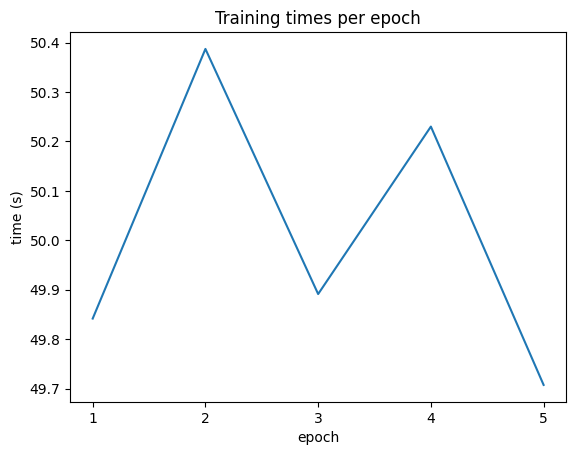

The average training time is: 50.01153879165649


In [15]:
plt.plot(range(1,6), times)
plt.xticks(range(1, 6))
plt.xlabel('epoch')
plt.ylabel('time (s)')
plt.title('Training times per epoch')
plt.show()
print(f"The average training time is: {np.mean(times)}")

### Convolution filters

Finally, we display some of the learned convolution filters. The weights are deterministic. They stay unchanged after each call of the cell below.

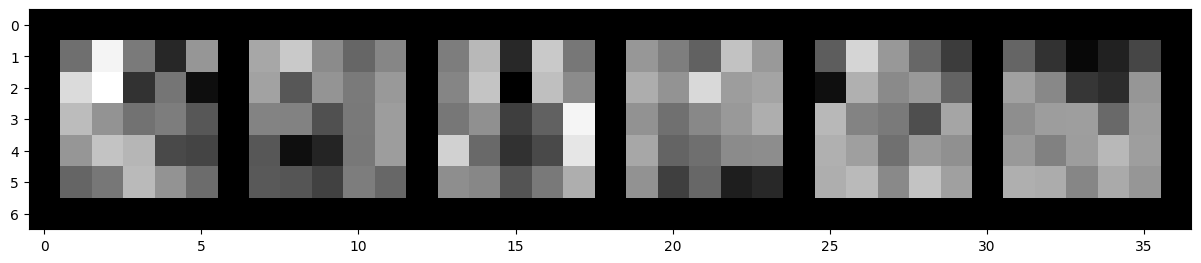

In [16]:
filters = (model.conv1.weight.clone().cpu())#+model.conv1.bias[:, None, None, None]).clone()
out_c, in_c, h, w = filters.shape
filters = filters.view(out_c*in_c, -1, h, w)
n_col = 16
rows = np.min((filters.shape[0] // n_col+1, 32))
grid = utils.make_grid(filters, nrow=n_col, normalize=True, padding=1)
plt.figure(figsize=(15, 15))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.show()

# Bayesian CNN

Now we switch to the Bayesian setting and train the same model with online marginal likelihood optimisation method. All of the model's parameters are affected.

We measure training times and explore learned convolutional filters.

### Bayesian loop

We take the original marginal likelihood training loop and add time logging.

In [24]:
def marglik_training_test(
    model,
    train_loader,
    likelihood='classification',
    hessian_structure='kron',
    backend=AsdlGGN,
    optimizer_cls=Adam,
    optimizer_kwargs=None,
    scheduler_cls=None,
    scheduler_kwargs=None,
    n_epochs=300,
    lr_hyp=1e-1,
    prior_structure='layerwise',
    n_epochs_burnin=0,
    n_hypersteps=10,
    marglik_frequency=1,
    prior_prec_init=1.,
    sigma_noise_init=1.,
    temperature=1.,
    wandb_run = None,
):
    # if 'weight_decay' in optimizer_kwargs:
    #     warnings.warn('Weight decay is handled and optimized. Will be set to 0.')
    #     optimizer_kwargs['weight_decay'] = 0.0

    # get device, data set size N, number of layers H, number of parameters P
    device = parameters_to_vector(model.parameters()).device
    print(f"the model is on {device}")
    N = len(train_loader.dataset)
    H = len(list(model.parameters()))
    P = len(parameters_to_vector(model.parameters()))

    times_nn = []
    times_laplace_fit = []
    times_hypersteps = []

    # differentiable hyperparameters
    hyperparameters = list()
    # prior precision
    log_prior_prec_init = np.log(temperature * prior_prec_init)
    if prior_structure == 'scalar':
        log_prior_prec = log_prior_prec_init * torch.ones(1, device=device)
    elif prior_structure == 'layerwise':
        log_prior_prec = log_prior_prec_init * torch.ones(H, device=device)
    elif prior_structure == 'diagonal':
        log_prior_prec = log_prior_prec_init * torch.ones(P, device=device)
    else:
        raise ValueError(f'Invalid prior structure {prior_structure}')
    log_prior_prec.requires_grad = True
    hyperparameters.append(log_prior_prec)

    # set up loss (and observation noise hyperparam)
    if likelihood == 'classification':
        criterion = CrossEntropyLoss(reduction='mean')
        sigma_noise = 1.
    elif likelihood == 'regression':
        criterion = MSELoss(reduction='mean')
        log_sigma_noise_init = np.log(sigma_noise_init)
        log_sigma_noise = log_sigma_noise_init * torch.ones(1, device=device)
        log_sigma_noise.requires_grad = True
        hyperparameters.append(log_sigma_noise)

    # set up model optimizer
    if optimizer_kwargs is None:
        optimizer_kwargs = dict()
    optimizer = optimizer_cls(model.parameters(), **optimizer_kwargs)

    # set up learning rate scheduler
    if scheduler_cls is not None:
        if scheduler_kwargs is None:
            scheduler_kwargs = dict()
        scheduler = scheduler_cls(optimizer, **scheduler_kwargs)

    # set up hyperparameter optimizer
    hyper_optimizer = Adam(hyperparameters, lr=lr_hyp)

    best_marglik = np.inf
    best_model_dict = None
    best_precision = None
    losses = list()
    margliks = list()

    for epoch in range(1, n_epochs + 1):
        print(f"epoch {epoch}")
        epoch_loss = 0
        epoch_perf = 0

        # standard NN training per batch
        t0 = time.time()
        for i, data in enumerate(train_loader):
            X, y = data
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            if likelihood == 'regression':
                sigma_noise = torch.exp(log_sigma_noise).detach()
                crit_factor = temperature / (2 * sigma_noise.square())
            else:
                crit_factor = temperature
            prior_prec = torch.exp(log_prior_prec).detach()
            theta = parameters_to_vector(model.parameters())
            delta = expand_prior_precision(prior_prec, model)
            f = model(X)
            loss = criterion(f, y) + (0.5 * (delta * theta) @ theta) / N / crit_factor
            loss.backward()
            optimizer.step()
            epoch_loss += loss.cpu().item() * len(y)
            if likelihood == 'regression':
                epoch_perf += (f.detach() - y).square().sum()
            else:
                epoch_perf += torch.sum(torch.argmax(f.detach(), dim=-1) == y).item()
            if scheduler_cls is not None:
                scheduler.step()
            if i % 1000 == 999:
                last_loss = epoch_loss / 1000 # loss per batch
                print('  batch {} loss: {}'.format(i + 1, last_loss))

        losses.append(epoch_loss / N)


        t1 = time.time()
        times_nn.append(t1-t0)
        print(t1-t0)

        # compute validation error to report during training
        print(f'MARGLIK[epoch={epoch}]: network training. Loss={losses[-1]:.3f}.' +
                     f'Perf={epoch_perf/N:.3f}')

        # wandb logging
        if wandb_run is not None:
            wandb_run.log({"NN training time" : times_nn[-1]}, commit=False)
            wandb_run.log({"Training loss" : losses[-1],
                     "Accuracy": epoch_perf/N}, commit=False)
        # only update hyperparameters every marglik_frequency steps after burnin
        if (epoch % marglik_frequency) != 0 or epoch < n_epochs_burnin:
            continue

        # optimizer hyperparameters by differentiating marglik
        # 1. fit laplace approximation

        t0 = time.time()
        sigma_noise = 1 if likelihood == 'classification' else torch.exp(log_sigma_noise)
        prior_prec = torch.exp(log_prior_prec)
        lap = Laplace(
            model, likelihood, hessian_structure=hessian_structure, sigma_noise=sigma_noise,
            prior_precision=prior_prec, temperature=temperature, backend=backend,
            subset_of_weights='all'
        )

        lap.fit(train_loader)
        t1 = time.time()


        times_laplace_fit.append(t1- t0)
        if wandb_run is not None:
            wandb_run.log({"Laplace fit time" : times_laplace_fit[-1]}, commit=False)


        # 2. differentiate wrt. hyperparameters for n_hypersteps
        t0 = time.time()
        for _ in range(n_hypersteps):
            hyper_optimizer.zero_grad()
            if likelihood == 'classification':
                sigma_noise = None
            elif likelihood == 'regression':
                sigma_noise = torch.exp(log_sigma_noise)
            prior_prec = torch.exp(log_prior_prec)
            marglik = -lap.log_marginal_likelihood(prior_prec, sigma_noise)
            marglik.backward()
            hyper_optimizer.step()
            margliks.append(marglik.item())
        t1 = time.time()


        times_hypersteps.append(t1-t0)
        if wandb_run is not None:
            wandb_run.log({"Hyperstep time" : times_hypersteps[-1]}, commit=False)

        # early stopping on marginal likelihood
        if margliks[-1] < best_marglik:
            best_model_dict = deepcopy(model.state_dict())
            best_precision = deepcopy(prior_prec.detach())
            best_sigma = 1 if likelihood == 'classification' else deepcopy(sigma_noise.detach())
            best_marglik = margliks[-1]
            print(f'MARGLIK[epoch={epoch}]: marglik optimization. MargLik={best_marglik:.2f}. '
                         + 'Saving new best model.')
            if wandb_run is not None:
                wandb_run.log({"MargLik" : best_marglik}, commit=True)

        else:
            print(f'MARGLIK[epoch={epoch}]: marglik optimization. MargLik={margliks[-1]:.2f}.'
                         + f'No improvement over {best_marglik:.2f}')
            if wandb_run is not None:
                wandb_run.log({"MargLik" : best_marglik}, commit=True)

    print('MARGLIK: finished training. Recover best model and fit Laplace.')
    t0 = time.time()
    if best_model_dict is not None:
        model.load_state_dict(best_model_dict)
        sigma_noise = best_sigma
        prior_prec = best_precision
    lap = Laplace(
        model, likelihood, hessian_structure=hessian_structure, sigma_noise=sigma_noise,
        prior_precision=prior_prec, temperature=temperature, backend=backend,
        subset_of_weights='all'
    )
    lap.fit(train_loader)
    t1 = time.time()
    times_laplace_fit.append(t1-t0)
    wandb.log({"Laplace fit time" : times_laplace_fit[-1]}, commit=True)
    return lap, model, margliks, losses, times_nn, times_laplace_fit, times_hypersteps


The hyperparemeters are taken accordingly to the authors' experiments. We decrease the number of epochs to 5 since we mostly care about computational performance and not the final accuracy.

In [18]:

EPOCHS = 5
learning_rate = 0.001
n_steps = EPOCHS*len(training_loader)
lr_min = 1e-6

In [26]:
# run = None

run = wandb.init(

    project="Bayesian-ML",

    config={
        "model" : "Laplace",
        "learning_rate": learning_rate,
        "epochs": EPOCHS,
        "min_lr": lr_min,
        "T_max": n_steps
    },
)

model_bayes = LeNet().to(device)

optimizer = torch.optim.Adam(model_bayes.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_steps, eta_min=lr_min)


la, model_bayes, margliks, losses, times_nn, times_laplace_fit, times_hypersteps = marglik_training_test(
    model=model_bayes,
    train_loader=training_loader,
    likelihood='classification',
    hessian_structure='kron', backend=AsdlGGN, n_epochs=EPOCHS,
    optimizer_kwargs={'lr': learning_rate},
    scheduler_cls=torch.optim.lr_scheduler.CosineAnnealingLR,
    scheduler_kwargs={"T_max": n_steps, "eta_min": lr_min},
    n_hypersteps=100,
    marglik_frequency=1,
    prior_structure='layerwise',
    wandb_run = run
)

trainig time,▂█▃▆▁
training loss,█▆▂▂▁
validation accuracy,▁▄▅██
validation loss,█▄▃▁▁
trainig time,49.70729
training loss,0.20463
validation accuracy,0.8966
validation loss,0.29195


the model is on cuda:0
epoch 1
  batch 1000 loss: 3.624757436387241
  batch 2000 loss: 6.16755478578899
  batch 3000 loss: 8.366930919251404
  batch 4000 loss: 10.541822311294265
  batch 5000 loss: 12.454512380092405
  batch 6000 loss: 14.393108335947618
  batch 7000 loss: 16.117417417651975
  batch 8000 loss: 17.799211156319828
  batch 9000 loss: 19.50622331841849
  batch 10000 loss: 21.175519060103223
  batch 11000 loss: 22.75711616810784
  batch 12000 loss: 24.41268183570914
  batch 13000 loss: 25.96729712621961
  batch 14000 loss: 27.51403656077292
  batch 15000 loss: 29.028045988420956
69.8289897441864
MARGLIK[epoch=1]: network training. Loss=0.484.Perf=0.822
MARGLIK[epoch=1]: marglik optimization. MargLik=31494.37. Saving new best model.
epoch 2
  batch 1000 loss: 1.6992835618704558
  batch 2000 loss: 3.3505527228564023
  batch 3000 loss: 4.989981591552496
  batch 4000 loss: 6.542297879889608
  batch 5000 loss: 8.137443295955658
  batch 6000 loss: 9.688625100031494
  batch 7000 l

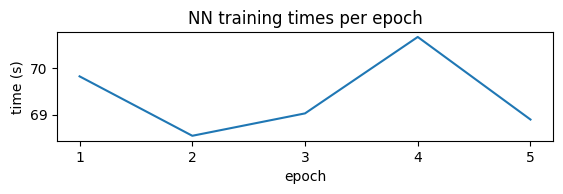

The average NN training time is: 69.39333138465881


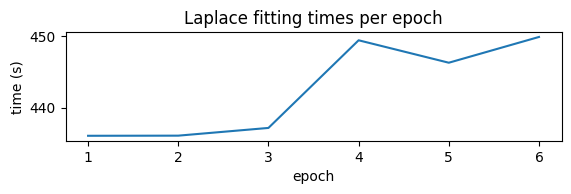

The average Laplace fit time is: 442.4852791627248


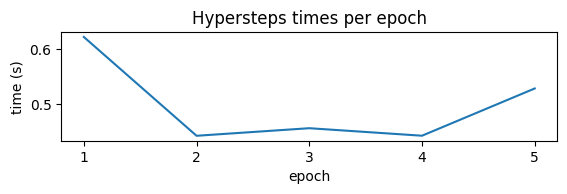

The average hypersteps time is: 0.49864606857299804


In [45]:
plt.subplot(3, 1, 1)
plt.plot(range(1,6), times_nn)
plt.xticks(range(1, 6))
plt.xlabel('epoch')
plt.ylabel('time (s)')
plt.title('NN training times per epoch')
plt.show()
print(f"The average NN training time is: {np.mean(times_nn)}")

plt.subplot(3, 1, 2)
plt.plot(range(1,7), times_laplace_fit)
plt.xticks(range(1, 7))
plt.xlabel('epoch')
plt.ylabel('time (s)')
plt.title('Laplace fitting times per epoch')
plt.show()
print(f"The average Laplace fit time is: {np.mean(times_laplace_fit)}")

plt.subplot(3, 1, 3)
plt.plot(range(1,6), times_hypersteps)
plt.xticks(range(1, 6))
plt.xlabel('epoch')
plt.ylabel('time (s)')
plt.title('Hypersteps times per epoch')
plt.show()
print(f"The average hypersteps time is: {np.mean(times_hypersteps)}")

Calculating the validation accuracy

In [28]:
with torch.no_grad():
    correct = torch.Tensor().to(device)
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs = vinputs.to(device)
        vlabels = vlabels.to(device)
        voutputs = la(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss
        voutputs = torch.max(voutputs, dim=1)[1]
        correct = torch.cat((correct, voutputs==vlabels))

    val_acc = torch.sum(correct)/correct.shape[0]

In [29]:
val_acc

tensor(0.9003, device='cuda:0')

### Convolution filters

Here we present MAP estimaties. They are fixed. Rerunnning the cell below keeps filters unchanged.

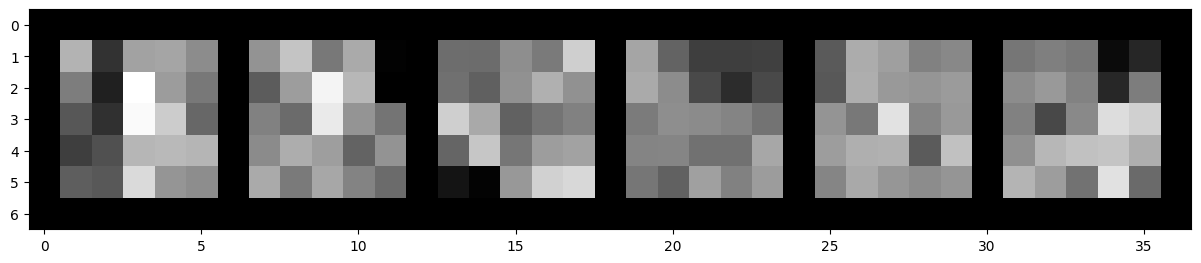

In [34]:
filters = (model_bayes.conv1.weight.clone().cpu())#+model.conv1.bias[:, None, None, None]).clone()
out_c, in_c, h, w = filters.shape
filters = filters.view(out_c*in_c, -1, h, w)
n_col = 16
rows = np.min((filters.shape[0] // n_col+1, 32))
grid = utils.make_grid(filters, nrow=n_col, normalize=True, padding=1)
plt.figure(figsize=(15, 15))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.show()

Now we use the fitted Laplace approximation to demosntrated sampled weights. Each rerun of the cell below resamples model's parameters and demonstrates the filters.

The changes of filters are often subtle, thus we additionally print the numeric values of the filters.

tensor([[[ 0.1678, -0.3090,  0.0711,  0.0813, -0.0118],
         [-0.0624, -0.3573,  0.4270,  0.0800, -0.0162],
         [-0.1589, -0.3795,  0.4315,  0.1986, -0.1270],
         [-0.2636, -0.2744,  0.1921,  0.1857,  0.1353],
         [-0.2040, -0.1233,  0.2492,  0.0839, -0.0140]]],
       grad_fn=<SelectBackward0>)


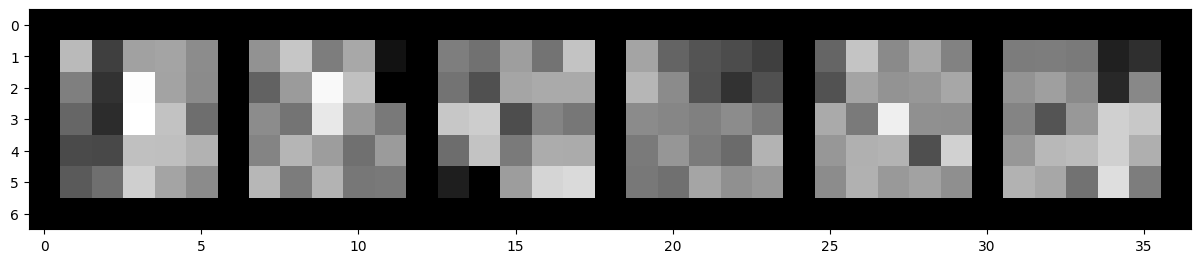

In [41]:
# we sample all parameters at once
vector_to_parameters(la.sample(n_samples=1).view(-1,), model_bayes.parameters())

filters = model_bayes.conv1.weight.clone().cpu()#+model.conv1.bias[:, None, None, None]).clone()
out_c, in_c, h, w = filters.shape
filters = filters.view(out_c*in_c, -1, h, w)
n_col = 16
rows = np.min((filters.shape[0] // n_col+1, 32))
grid = utils.make_grid(filters, nrow=n_col, normalize=True, padding=1)
plt.figure(figsize=(15, 15))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
print(filters[0])
plt.show()